# Análise da Documentação Técnica do Processo Licitatório

Análise dos documentos encaminhados para o processo licitatório por lotes.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import nltk
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sn

from text.process import text_processor

from utils.process_dataframe import * 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
    
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.callbacks import EarlyStopping

In [2]:

df_op = pd.read_csv(os.path.join('..', '..', '..', 'dataset', 'dataframe', '2020-12-15_dataframe_operacao_credito_raw.csv'))

df_t = pd.read_csv(os.path.join('..', '..', '..', 'dataset', 'dataframe', '2021-01-04_dataframe_treino.csv'))

df_op = df_op[ df_op['tipo'] != 'ATO de mesa executiva0001-1.jpg']

df_t = df_t[df_t['modulo'] != 'operacao_credito']

df_t.drop(columns=['texto_limpo', 'texto_len', 'texto_limpo_len', 'qtd_palavras_texto', 'qtd_palavras_texto_limpo'], inplace=True)

# df_op[ df_op['tipo'] == 'ATO de mesa executiva0001-1.jpg' ].drop(inplace=True).reindex()
# df_t[df_t['modulo'] == 'operacao_credito'].drop(inplace=True).reindex()
df_t = pd.concat([df_t, df_op])

df_t.to_csv(os.path.join('..', '..', '..', 'dataset', 'dataframe', 'dataframe.csv'))


df_t.columns


Index(['projeto', 'texto', 'tipo', 'modulo'], dtype='object')

In [3]:
DEFAULT_DIR_DATAFRAME = os.path.join('..', '..', '..', 'dataset', 'dataframe')

mapeamento_alteracao_nome_tipos = load_json_or_default(os.path.join(DEFAULT_DIR_DATAFRAME, 'mapeamento_alteracao_nome_tipos.json'))
documentos_em_modulos_errados = load_json_or_default(os.path.join(DEFAULT_DIR_DATAFRAME, 'documentos_em_modulos_errados.json'))
documentos_com_tipologia_errada = load_json_or_default(os.path.join(DEFAULT_DIR_DATAFRAME, 'documentos_com_tipologia_errada.json'))


In [60]:
RANDOM_STATE = 42
# CSV_PATH = '../../../dataset/dataframe/raw/2020-12-15_dataframe_processo_licitatorio_tecnico_raw.csv'
CSV_PATH = '../../../dataset/dataframe/raw/2020-12-15_dataframe_processo_licitatorio_tecnico_raw.csv'

df = pd.read_csv(CSV_PATH)
print('Num. Linhas: {}'.format( len(df.index) ))

df.head(5)

Num. Linhas: 2477


projeto  \
0  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   
1  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   
2  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   
3  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   
4  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   

                                               texto  \
0  tesooomscençar cao\nOncr-+ESE (89) Mv - 672 na...   
1  CRONOGRAMA FÍSICO-FINANCEIRO - Modelo 09\n\n \...   
2  fee ouueiuasoidau\nUa/dSS iesep Leve ou\nBESSA...   
3  fee ouueiuasoidau\nUa/dSS iesep Leve ou\nBESSA...   
4  TEZEOSTSTOELNOTOT /ONIOS] UBNEISSpINç io apepo...   

                                           tipo                        modulo  
0       Proposta comercial da empresa vencedora  processo_licitatorio_tecnico  
1                  Cronograma físico financeiro  processo_licitatorio_tecnico  
2             Planilha de orçamento - Ganhadora  processo_licitatorio_tecnico  
3                      Características técnicas  processo_licitatorio_tecnico  
4  Parecer Juridico do Procedimento Licitatorio  processo_licitatorio_tecnico

In [61]:
tipos = df.tipo.unique()

print('Qtd Tipos diferentes: {}'.format(len(tipos)))
for tipo in tipos:
    print('{:80s} {:6d}'.format(tipo, len(df[df['tipo'] == tipo].index) ))


Qtd Tipos diferentes: 12
Proposta comercial da empresa vencedora                                             695
Cronograma físico financeiro                                                        357
Planilha de orçamento - Ganhadora                                                   383
Características técnicas                                                            325
Parecer Juridico do Procedimento Licitatorio                                        666
Estudo Luminotécnico de conformidade à NBR 5101-2018, elaborado no DIALux            10
Catálogo com as características técnicas                                             12
Certificado de Conformidade e Registro no INMETRO                                    13
Carta de Garantia emitida pelo fabricante                                            10
Parecer jurídico do edital do Processo Licitatório                                    4
Características tecnicas                                                              1
Caracte

In [62]:
projetos = df.projeto.unique()

print('Qtd projetos diferentes: {}'.format(len(projetos)))
for projeto in projetos:
    print('{:80s} {:6d}'.format(projeto, len(df[df['projeto'] == projeto].index) ))

                      4
Kaloré - proj 42 - processo 1 - lote 1                                                4
Guaíra - proj 43 - processo 1 - lote 1                                                5
Bandeirantes - proj 65 - processo 1 - lote 1                                          3
Marquinho - proj 39 - processo 1 - lote 1                                             4
Entre Rios do Oeste - proj 34 - processo 1 - lote 1                                   4
Nova Aurora - proj 40 - processo 1 - lote 1                                           4
Inácio Martins - proj 43 - processo 1 - lote 1                                        4
Araruna - proj 31 - processo 1 - lote 1                                               3
Ipiranga - proj 36 - processo 1 - lote 1                                              3
Kaloré - proj 45 - processo 1 - lote 1                                                4
Roncador - proj 24 - processo 1 - lote 2                                              2
Roncador

In [5]:

df.groupby('tipo').count()['projeto'].sort_values(ascending=False)[:10].plot(kind='bar')



NameError: name 'df' is not defined

<AxesSubplot:xlabel='tipo'>

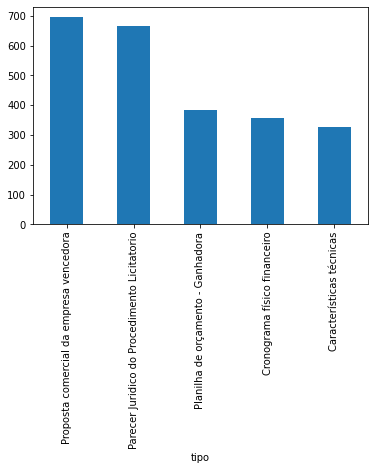

In [64]:

# TOP five
df.groupby('tipo').count()['projeto'].sort_values(ascending=False)[:5].plot(kind='bar')


In [65]:
df = df.drop(
    df[ ~df['tipo'].isin([
        'Características técnicas',
        'Proposta comercial da empresa vencedora',
        'Planilha de orçamento - Ganhadora',
        'Cronograma físico financeiro'
    ])].index
)

df.head()

projeto  \
0  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   
1  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   
2  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   
3  Bom Jesus do Sul - proj 17 - processo 1 - lote 1   
5          Cascavel - proj 96 - processo 1 - lote 1   

                                               texto  \
0  tesooomscençar cao\nOncr-+ESE (89) Mv - 672 na...   
1  CRONOGRAMA FÍSICO-FINANCEIRO - Modelo 09\n\n \...   
2  fee ouueiuasoidau\nUa/dSS iesep Leve ou\nBESSA...   
3  fee ouueiuasoidau\nUa/dSS iesep Leve ou\nBESSA...   
5  CONCORRÊNCIA nº 009/2020 Folha nº 0// q)\n\nMo...   

                                      tipo                        modulo  
0  Proposta comercial da empresa vencedora  processo_licitatorio_tecnico  
1             Cronograma físico financeiro  processo_licitatorio_tecnico  
2        Planilha de orçamento - Ganhadora  processo_licitatorio_tecnico  
3                 Características técnicas  processo_licitatorio_tecnico  
5  Proposta comercial da empresa vencedora  processo_licitatorio_tecnico

In [66]:

len(df.index)

tipos = df.tipo.unique()
print('Qtd Tipos diferentes: {}'.format(len(tipos)))
for tipo in tipos:
    print('{:80s} {:6d}'.format(tipo, len(df[df['tipo'] == tipo].index) ))

Qtd Tipos diferentes: 4
Proposta comercial da empresa vencedora                                             695
Cronograma físico financeiro                                                        357
Planilha de orçamento - Ganhadora                                                   383
Características técnicas                                                            325


In [10]:

df['texto'] = df['texto'].astype(str).apply(lambda x: x.replace("\n", " "))
df['texto_limpo'] = df['texto'].astype(str).apply(text_processor.clear_words)
# df['texto_stemmed'] = df['texto_limpo'].astype(str).apply(text_processor.stem_sentence)
df['texto_len'] = df['texto'].astype(str).apply(len)
df['texto_limpo_len'] = df['texto_limpo'].astype(str).apply(len)
# df['texto_stemmed_len'] = df['texto_stemmed'].astype(str).apply(len)
df['qtd_palavras_texto'] = df['texto'].apply(lambda x: len(str(x).split()))
df['qtd_palavras_texto_limpo'] = df['texto_limpo'].apply(lambda x: len(str(x).split()))
# df['qtd_palavras_texto_stemmed'] = df['texto_stemmed'].apply(lambda x: len(str(x).split()))
df.sample(5)



projeto  \
1408        Mandirituba - proj 33 - processo 1 - lote 2   
709       Cidade Gaúcha - proj 42 - processo 1 - lote 1   
1898           Tomazina - proj 12 - processo 1 - lote 1   
980   Assis Chateaubriand - proj 57 - processo 1 - l...   
2326       Sertanópolis - proj 29 - processo 1 - lote 1   

                                                  texto  \
1408  RAZAO SOCIAL: RC RENA CONSTRUCOES E SERVICOS L...   
709   Vaslar:          PROPONENTE: RODO SERVICE LTDA...   
1898  PROPOSTA DE PREÇOS  | PREFEITURA MUNICIPAL DE ...   
980   JQUIODJou JQUBJOS :jjew-3  “q uIOo WengosQueno...   
2326  PLANILHA DE SERVIÇOS - CONSTRUÇÃO CIVIL       ...   

                                         tipo                        modulo  \
1408             Cronograma físico financeiro  processo_licitatorio_tecnico   
709   Proposta comercial da empresa vencedora  processo_licitatorio_tecnico   
1898  Proposta comercial da empresa vencedora  processo_licitatorio_tecnico   
980         Planilha de orçamento - Ganhadora  processo_licitatorio_tecnico   
2326        Planilha de orçamento - Ganhadora  processo_licitatorio_tecnico   

                                            texto_limpo  texto_len  \
1408  razao social rena construcoes servicos ltda cn...       1764   
709   vaslar proponente rodo service ltda endereço r...       1850   
1898  proposta preços prefeitura municipal tomazina ...       3189   
980   jquiodjou jqubjos jjew-3 uioo wengosquenos jje...       4957   
2326  planilha serviços construção civil município s...       7714   

      texto_limpo_len  qtd_palavras_texto  qtd_palavras_texto_limpo  
1408             1117                 323                       165  
709              1404                 286                       184  
1898             2318                 504                       295  
980              3405                 799                       410  
2326             5514                1199                       668

<AxesSubplot:>

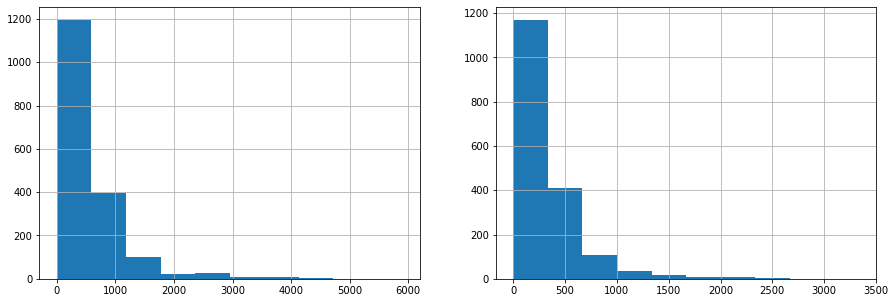

In [11]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df['qtd_palavras_texto'].hist(ax=axes[0])
df['qtd_palavras_texto_limpo'].hist(ax=axes[1])



In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Média de palavras por tipo de documento
df.groupby('tipo')['qtd_palavras_texto'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[0])
df.groupby('tipo')['qtd_palavras_texto_limpo'].mean().sort_values(ascending=False).plot(kind='bar', ax=axes[1])


<AxesSubplot:xlabel='tipo'>

Características técnicas                        AxesSubplot(0.1,0.559091;0.363636x0.340909)
Cronograma físico financeiro               AxesSubplot(0.536364,0.559091;0.363636x0.340909)
Planilha de orçamento - Ganhadora                   AxesSubplot(0.1,0.15;0.363636x0.340909)
Proposta comercial da empresa vencedora        AxesSubplot(0.536364,0.15;0.363636x0.340909)
dtype: object

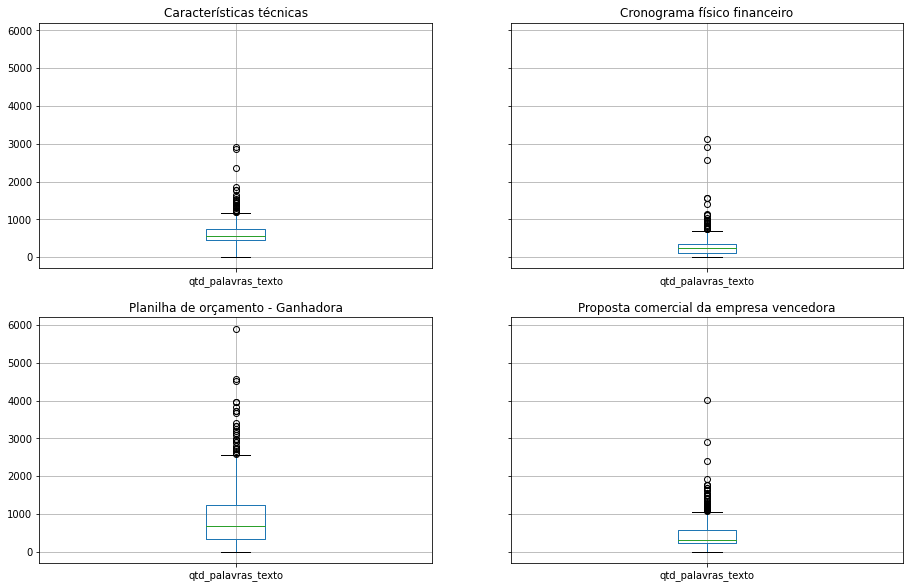

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
df.groupby('tipo').boxplot(column='qtd_palavras_texto',ax=axes)


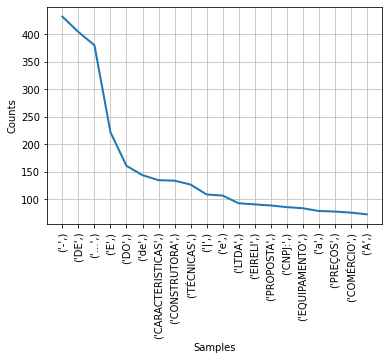

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [31]:
#uni-gram
text = df.texto.to_string().split()
ngs = nltk.ngrams(text, 1)
fdist = nltk.FreqDist(ngs)
fdist.plot(20)


#uni-gram texto sem stopwords
text = df.texto_limpo.to_string().split()
ngs = nltk.ngrams(text, 1)
fdist_limpo = nltk.FreqDist(ngs)
fdist_limpo.plot(20)




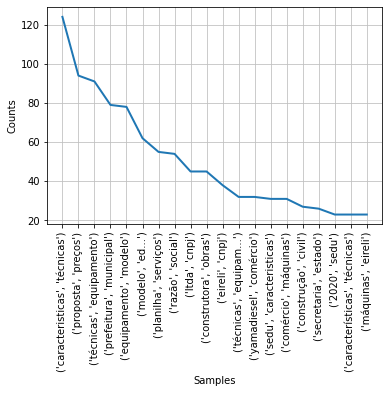

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [32]:
#bi-gram
text = df.texto.to_string().split()
ngs = nltk.ngrams(text, 2)
fdist = nltk.FreqDist(ngs)
fdist.plot(20)


#bi-gram texto sem stopwords
text = df.texto_limpo.to_string().split()
ngs = nltk.ngrams(text, 2)
fdist_limpo = nltk.FreqDist(ngs)
fdist_limpo.plot(20)

In [33]:

from text.feature_extraction import feature_extractor

encoder = OneHotEncoder(sparse=False)
X = df.texto_limpo.values
# X = df.texto_stemmed.values
y = encoder.fit_transform(df.tipo.values.reshape(len(df.tipo.values), 1))

vectorizer =  TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', max_features=1000)
vectorizer.fit( X )
X = vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

input_dim = X_train.shape[1]


In [34]:

y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

d_class_weights


{0: 1.375, 1: 1.2222222222222223, 2: 1.1428571428571428, 3: 0.6330935251798561}

In [35]:
X_train.sort_indices()
X_test.sort_indices()


In [16]:
from sklearn.ensemble import RandomForestClassifier 

classifier = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)  
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
# cm = confusion_matrix(y_test, predictions)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Recall score: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
# print(cm)

Accuracy score: 0.8409
Precision score: 0.9367
Recall score: 0.8409


In [102]:
# from model.tiny_rna import TinyRNA

# rna = TinyRNA()

# rna.build(input_dim, 4)

# model = rna.get_base_model()
# model.summary()



def get_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(8, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(0.15))
    model.add(layers.BatchNormalization())

    # model.add(layers.Dense(16, input_dim=input_dim, activation='relu'))
    # model.add(layers.Dropout(0.15))
    # model.add(layers.BatchNormalization())

    model.add(layers.Dense(4, activation='softmax'))
    return model


model = get_model(input_dim)



In [25]:
callbacks = []

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = [es]

optimizer = Adam(lr=0.0001)
# optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)
# history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, class_weight=d_class_weights)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, class_weight=d_class_weights, callbacks=[es])
# history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, callbacks=[es])



Epoch 1/50
189/189 [==============================] - 0s 2ms/step - loss: 0.7846 - acc: 0.7688 - val_loss: 0.4364 - val_acc: 0.9053
Epoch 2/50
189/189 [==============================] - 0s 1ms/step - loss: 0.7783 - acc: 0.7615 - val_loss: 0.4372 - val_acc: 0.9020
Epoch 3/50
189/189 [==============================] - 0s 1ms/step - loss: 0.7681 - acc: 0.7687 - val_loss: 0.4362 - val_acc: 0.9040
Epoch 4/50
189/189 [==============================] - 0s 1ms/step - loss: 0.7348 - acc: 0.7723 - val_loss: 0.4323 - val_acc: 0.9040
Epoch 5/50
189/189 [==============================] - 0s 1ms/step - loss: 0.7660 - acc: 0.7687 - val_loss: 0.4320 - val_acc: 0.9033
Epoch 6/50
189/189 [==============================] - 0s 1ms/step - loss: 0.7639 - acc: 0.7693 - val_loss: 0.4333 - val_acc: 0.9033
Epoch 7/50
189/189 [==============================] - 0s 1ms/step - loss: 0.7977 - acc: 0.7751 - val_loss: 0.4323 - val_acc: 0.9026
Epoch 8/50
189/189 [==============================] - 0s 1ms/step - loss: 0.

In [101]:


def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    



plot_history(history)


Acc Treino: 0.9148
Acc Teste:  0.8523


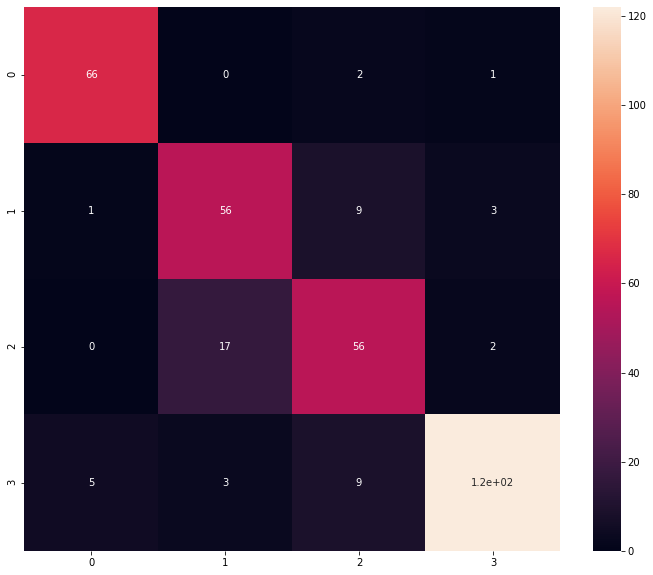

In [104]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Acc Treino: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Acc Teste:  {:.4f}".format(accuracy))


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# y_pred = model.predict(X_train)
# cm = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))


df_cm = pd.DataFrame(cm)
plt.figure(figsize = (12, 10))
sn.heatmap(df_cm, annot=True)
plt.show()

In [105]:
from sklearn.metrics import classification_report,precision_score

labels = [label[:25] for label in list(df.tipo.unique())]

y_true = y_test.argmax(axis=1)
# y_pred = y_pred.argmax(axis=1)
print(classification_report(y_true, y_pred.argmax(axis=1) , target_names=labels))

                           precision    recall  f1-score   support

Proposta comercial da emp       0.92      0.96      0.94        69
Cronograma físico finance       0.74      0.81      0.77        69
Planilha de orçamento - G       0.74      0.75      0.74        75
 Características técnicas       0.95      0.88      0.91       139

                 accuracy                           0.85       352
                macro avg       0.84      0.85      0.84       352
             weighted avg       0.86      0.85      0.85       352



In [9]:

tipos = sorted(df.tipo.unique())

i = 0
for tipo in sorted(tipos):
    print('{} - {}'.format(i, tipo))
    encode = encoder.transform( np.array([tipo]).reshape(1, -1) )
    print(encode[0])
    i += 1


0 - Atas do Processo Licitatório
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 - Características técnicas
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 - Cronograma físico financeiro
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 - Declaração das proponentes declinando do prazo recursal
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 - Declaração de inexistência de recursos
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 - Edital de classificação
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 - Edital de habilitação
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
7 - Edital do Processo Licitatório
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
8 - Parecer Juridico minuta edital
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
9 - Planilha de orçamento - Ganhadora
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
10 - Portaria designando a comissão de licitação
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
11 - Proposta comercial da empresa vencedora
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [107]:

tipo = 'Planilha de orçamento - GanhadoraTamarana - proj 20 - processo 1 - lote 1'

df_validation = df[df['tipo'] == tipo]

textos = df_validation.texto_limpo.values.astype('U') 

for i in range(len(df_validation.index)):
    
    X_valid = textos[i]
    X_valid = vectorizer.transform([X_valid])

    X_valid.sort_indices()

    predicted = model.predict(X_valid)
    label_predicted = encoder.inverse_transform( np.array(predicted[0]).reshape(1, -1) )[0][0]
    label_expected = df_validation.iloc[i].tipo
    
    if label_predicted != label_expected:
        print('{} Proj: {} - Expected: {} - Predicted: {}'.format(i, df_validation.iloc[i].projeto, label_expected, label_predicted))
        print(df_validation.iloc[i].texto[:100])
        print('\n')
        

## Treino de rede com outros modulos

Treino do texto extraído dos documentos da parte técnica do processo licitatório com os outros módulos.

Os dataframes devem estar processados.




In [4]:
# from utils import process_dataframe
from utils import train

print(DEFAULT_DIR_DATAFRAME)
# df = load_dataframes_in_dir(os.path.join(DEFAULT_DIR_DATAFRAME, 'processed'))
df = train.load_processed_dataframe(os.path.join(DEFAULT_DIR_DATAFRAME, 'processed'))

print('Limpando dataframe...')
df = clear_dataframe(df, mapeamento_alteracao_nome_tipos, documentos_em_modulos_errados, documentos_com_tipologia_errada)

print('Modulos: ')
for modulo in df.modulo.unique():
    print(modulo)

print('Número de linhas: {}'.format(len(df.index)) )



../../../dataset/dataframe
Limpando dataframe...
Modulos: 
processo_licitatorio_juridico
processo_licitatorio_tecnico
operacao_credito
Número de linhas: 7489


In [19]:

df.columns



Index(['projeto', 'texto', 'tipo', 'modulo', 'texto_limpo', 'texto_len',
       'texto_limpo_len', 'qtd_palavras_texto', 'qtd_palavras_texto_limpo'],
      dtype='object')

In [12]:
# df[ df['tipo'] == 'Ata de Posse do(a) Prefeito(a) Municipal']
# df[ df['tipo'] == 'Edital de habilitação']
# df[ (df['projeto'] == 'Irati - proj 64 - processo 1') ]


projeto  \
957  Irati - proj 64 - processo 1   
958  Irati - proj 64 - processo 1   
959  Irati - proj 64 - processo 1   
960  Irati - proj 64 - processo 1   
961  Irati - proj 64 - processo 1   
962  Irati - proj 64 - processo 1   
963  Irati - proj 64 - processo 1   

                                                 texto  \
957  PREFEITURA DE  IRATI Gabinete           DECRET...   
958  y MUNICÍPIO DE IRATI dies,  EDITAL DE PREGÃO E...   
959  [go [espe estica  Conrad: R$ 4.418,00 (Qua mi,...   
960  PREFEITURA MUNICIPAL DE IRATI IRATI-PR  ATA DE...   
961  PREFEITURA MUNIC IPAL DE IRATI  4/0001-82  Cen...   
962  & PREFEITURA DE  “IRATI  PREFEITURA MUNICIPAL ...   
963  PREFEITURA MUNICIPAL DE IRATI CNPH75,654.574/0...   

                                             tipo  \
957   Portaria designando a comissão de licitação   
958                Edital do Processo Licitatório   
959  Publicações do aviso do Processo Licitatório   
960                  Atas do Processo Licitatório   
961            Relatórios do Processo Licitatório   
962                Parecer Juridico minuta edital   
963        Declaração de inexistência de recursos   

                            modulo  \
957  processo_licitatorio_juridico   
958  processo_licitatorio_juridico   
959  processo_licitatorio_juridico   
960  processo_licitatorio_juridico   
961  processo_licitatorio_juridico   
962  processo_licitatorio_juridico   
963  processo_licitatorio_juridico   

                                           texto_limpo  texto_len  \
957  prefeitura irati gabinete decreto 182/2020 sum...       4498   
958  município irati dies edital pregão eletrônico ...      53674   
959  espe estica conrad 418 qua quatrocentos quaren...      34906   
960  prefeitura municipal irati irati-pr ata sessão...       2988   
961  prefeitura munic ipal irati 4/0001-82 centro l...       4490   
962  prefeitura irati prefeitura municipal irati pa...        607   
963  prefeitura municipal irati cnph75 654 574/0001...        871   

     texto_limpo_len  qtd_palavras_texto  qtd_palavras_texto_limpo  
957             3451                 696                       410  
958            39099                7959                      4375  
959            26386                5967                      3730  
960             2275                 379                       273  
961             3396                 600                       393  
962              463                  92                        54  
963              674                 111                        74

In [14]:
from model.tiny_rna import TinyRNA
from model import tiny_rna

from text.feature_extraction.feature_extractor import TfidfFileExtractor

encoder = train.fit_new_encoder(df)
categories = encoder.categories_[0]

for category in categories:
    print(category)

print('# Categorias: {}'.format(len(categories)))

vectorizer = TfidfFileExtractor(max_features=tiny_rna.N_FEATURES)

# vectorizer = TfidfFileExtractor()
# vectorizer.load('./teste_vectorizer.pkl')

X, y = train.prepare_samples_to_model(df, vectorizer, encoder)

X_train = X 
y_train = y
X_test = np.array([])
y_test = np.array([])

print("Amostras de Treino:  {}".format(X_train.shape[0]))
print("Amostras de Teste:  {:.4f}".format(X_test.shape[0]))




Anexo I da LOA – Anexo publicado junto à LOA do exercício em curso ou conforme o modelo disponibilizado
Ata de Posse do(a) Prefeito(a) Municipal
Atas do Processo Licitatório
Características técnicas
Certidão SEFA - Certidão Negativa para Obtenção de novas operações de crédito
Certidão do TCE-PR – Especifica para Operação de Crédito
Cronograma físico financeiro
Declaração das proponentes declinando do prazo recursal
Declaração de inexistência de recursos
Decreto de abertura de crédito adicional
Edital de classificação
Edital de habilitação
Edital do Processo Licitatório
Ficha Cadastral
Lei Autorizadora
Lei abertura de crédito adicional
Ofício de Indicação de Conta de Débito
Outros - Operação de Crédito
Parecer Juridico minuta edital
Parecer Jurídico
Parecer Técnico
Planilha de orçamento - Ganhadora
Portaria designando a comissão de licitação
Proposta comercial da empresa vencedora
Publicações do aviso do Processo Licitatório
Recursos do Processo Licitatório
Relatórios do Processo Licita

In [15]:

# df['texto_limpo'].values.astype('U')

# df.head(1)

# vectorizer.transform(df['texto_limpo'].iloc[0])

# vectorizer.get_feature_names()
X.shape

# vectorizer.save('./teste_vectorizer.pkl')

# vectorizer.is_fitted()



(7489, 1000)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
validation_data = (X_test, y_test)


print("Amostras de Treino:  {}".format(X_train.shape[0]))
print("Amostras de Teste:  {}".format(X_test.shape[0]))


Amostras de Treino:  5991
Amostras de Teste:  1498


In [17]:

y_integers = np.argmax(y_train, axis=1)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers) , y_integers)
d_class_weights = dict(enumerate(class_weights))
# ajusta os pesos para as categorias inexistêntes no conjunto de treino
for i in range(len(categories)):
    if i not in d_class_weights:
        d_class_weights[i] = 0.0

d_class_weights

{0: 9.647342995169081,
 1: 3.9623015873015874,
 2: 0.47615641392465424,
 3: 0.8667534722222222,
 4: 3.5220458553791887,
 5: 2.8816738816738816,
 6: 0.8279436152570481,
 7: 1.9294685990338165,
 8: 0.5233228511530398,
 9: 4.437777777777778,
 10: 0.6869625042999656,
 11: 0.8469041560644615,
 12: 0.48132080019281753,
 13: 3.2630718954248366,
 14: 3.1251956181533647,
 15: 4.528344671201814,
 16: 2.8816738816738816,
 17: 27.73611111111111,
 18: 0.48766788766788766,
 19: 2.8816738816738816,
 20: 2.8816738816738816,
 21: 0.7840596780526109,
 22: 0.4887420460107685,
 23: 0.410145820497022,
 24: 0.4731106372897418,
 25: 3.6375227686703098,
 26: 0.4855336737174812}

In [18]:

callbacks = []
monitor = 'val_loss'
# monitor = 'loss'

es = EarlyStopping(monitor=monitor, mode='min', verbose=1, patience=5)
callbacks.append(es)


In [19]:

EPOCHS = 50
BATCH_SIZE = 32

model = TinyRNA()
model = train.prepare_model(model)

history = model.fit(X_train, y_train, 
    epochs=EPOCHS, 
    validation_data=validation_data, 
    batch_size=BATCH_SIZE,
    class_weight=d_class_weights,
    callbacks=callbacks)


Epoch 1/50
188/188 [==============================] - 0s 2ms/step - loss: 2.8281 - acc: 0.2544 - val_loss: 3.1026 - val_acc: 0.5701
Epoch 2/50
188/188 [==============================] - 0s 1ms/step - loss: 2.1351 - acc: 0.5251 - val_loss: 2.5627 - val_acc: 0.7777
Epoch 3/50
188/188 [==============================] - 0s 1ms/step - loss: 1.7544 - acc: 0.6390 - val_loss: 1.6993 - val_acc: 0.8371
Epoch 4/50
188/188 [==============================] - 0s 1ms/step - loss: 1.4755 - acc: 0.6949 - val_loss: 1.1949 - val_acc: 0.8665
Epoch 5/50
188/188 [==============================] - 0s 1ms/step - loss: 1.2832 - acc: 0.7356 - val_loss: 0.9855 - val_acc: 0.8778
Epoch 6/50
188/188 [==============================] - 0s 1ms/step - loss: 1.1281 - acc: 0.7743 - val_loss: 0.7821 - val_acc: 0.8939
Epoch 7/50
188/188 [==============================] - 0s 1ms/step - loss: 0.9688 - acc: 0.7967 - val_loss: 0.7243 - val_acc: 0.8919
Epoch 8/50
188/188 [==============================] - 0s 1ms/step - loss: 0.

In [20]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

labels = [str(i) + ' - ' + label[:25] for i, label in enumerate(categories)]

y_pred = model.predict(X_test)
y_true = y_test.argmax(axis=1)
# y_pred = y_pred.argmax(axis=1)

print(classification_report(y_true, y_pred.argmax(axis=1) , target_names=labels))

print('P: ', precision_score(y_true, y_pred.argmax(axis=1), average='micro'))
print('R: ', recall_score(y_true, y_pred.argmax(axis=1), average='micro'))
print('F1:', f1_score(y_true, y_pred.argmax(axis=1), average='micro'))




                                precision    recall  f1-score   support

 0 - Anexo I da LOA – Anexo pu       0.92      0.85      0.88        13
 1 - Ata de Posse do(a) Prefei       0.85      0.65      0.73        17
 2 - Atas do Processo Licitató       0.91      0.97      0.94       115
  3 - Características técnicas       0.98      0.95      0.96        56
 4 - Certidão SEFA - Certidão        1.00      0.94      0.97        16
 5 - Certidão do TCE-PR – Espe       0.80      0.89      0.84         9
 6 - Cronograma físico finance       0.81      0.91      0.86        65
 7 - Declaração das proponente       0.93      0.81      0.86        31
 8 - Declaração de inexistênci       0.98      0.98      0.98       122
 9 - Decreto de abertura de cr       0.80      0.86      0.83        14
  10 - Edital de classificação       0.86      0.83      0.84        71
    11 - Edital de habilitação       0.89      0.82      0.86        79
12 - Edital do Processo Licita       1.00      0.98      0.99  

In [21]:

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Acc Treino: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Acc Teste:  {:.4f}".format(accuracy))


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (12, 10))
sn.heatmap(df_cm, annot=True)
plt.show()



Acc Treino: 0.9633
Acc Teste:  0.9292


In [42]:

from sklearn.model_selection import KFold

acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
for train_data, test_data in kfold.split(X, y):
    model = TinyRNA()
    model = train.prepare_model(model)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train_data], y[train_data],
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

    # Generate generalization metrics
    scores = model.evaluate(X[test_data], y[test_data], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
211/211 [==============================] - 0s 1ms/step - loss: 2.5997 - acc: 0.3596
Epoch 2/50
211/211 [==============================] - 0s 1ms/step - loss: 1.8232 - acc: 0.6039
Epoch 3/50
211/211 [==============================] - 0s 1ms/step - loss: 1.4248 - acc: 0.6602
Epoch 4/50
211/211 [==============================] - 0s 989us/step - loss: 1.1978 - acc: 0.7039
Epoch 5/50
211/211 [==============================] - 0s 1ms/step - loss: 1.0251 - acc: 0.7441
Epoch 6/50
211/211 [==============================] - 0s 1ms/step - loss: 0.9128 - acc: 0.7699
Epoch 7/50
211/211 [==============================] - 0s 1ms/step - loss: 0.8198 - acc: 0.7896
Epoch 8/50
211/211 [==============================] - 0s 1ms/step - loss: 0.7611 - acc: 0.8064
Epoch 9/50
211/211 [==============================] - 0s 1ms/step - loss: 0.6929 - acc: 0.8246
Epoch 10/50
211/211 [=========================

KeyboardInterrupt: 

In [23]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5333665013313293 - Accuracy: 88.6693000793457%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4885093569755554 - Accuracy: 89.06455636024475%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4760555624961853 - Accuracy: 88.14229369163513%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4966968297958374 - Accuracy: 89.19631242752075%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.4664081335067749 - Accuracy: 90.25033116340637%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.5956202745437622 - Accuracy: 88.6693000793457%
------------------------------------------------------------------------
>

In [22]:


tipos = sorted(df.tipo.unique())

i = 0
for tipo in sorted(tipos):
    print('{} - {}'.format(i, tipo))
    encode = encoder.transform( np.array([tipo]).reshape(1, -1) )
    print(encode[0])
    i += 1




0 - Anexo I da LOA – Anexo publicado junto à LOA do exercício em curso ou conforme o modelo disponibilizado
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
1 - Ata de Posse do(a) Prefeito(a) Municipal
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
2 - Atas do Processo Licitatório
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
3 - Características técnicas
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
4 - Certidão SEFA - Certidão Negativa para Obtenção de novas operações de crédito
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
5 - Certidão do TCE-PR – Especifica para Operação de Crédito
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
6 - Cronograma físico financeiro
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
7 - Declaração das pr

In [91]:

tipo = 'Planilha de orçamento - Ganhadora'

df_validation = df[df['tipo'] == tipo]

textos = df_validation.texto_limpo.values.astype('U').tolist() 

for i in range(len(df_validation.index)):
    
    X_valid = textos[i]
    X_valid = vectorizer.transform([X_valid]).toarray()

    predicted = model.predict(X_valid)
    label_predicted = encoder.inverse_transform( np.array(predicted[0]).reshape(1, -1) )[0][0]
    label_expected = df_validation.iloc[i].tipo
    
    if label_predicted != label_expected:
        print('{} Proj: {} - Predicted: {} - Expected: {}'.format(i, df_validation.iloc[i].projeto, label_predicted, label_expected))
        print(df_validation.iloc[i].texto[:500])
        print('\n')
        



eus Giz 0) omBugiN-emaar o  SESoUININIaa SEIT = SUMiDE 55 WoBEjvasiaa Sp o


4 Proj: Fazenda Rio Grande - proj 58 - processo 1 - lote 1 - Predicted: Cronograma físico financeiro - Expected: Planilha de orçamento - Ganhadora
aum  ELE TH     OV5VININIAVA - SC5ANAS JG VHTINVIA     /4    


9 Proj: Chopinzinho - proj 54 - processo 1 - lote 1 - Predicted: Anexo I da LOA – Anexo publicado junto à LOA do exercício em curso ou conforme o modelo disponibilizado - Expected: Planilha de orçamento - Ganhadora
T TEN Ê rot fra y mv ari ivo sn DO Out oovern HO RIOS CO or AO am raso | em [oeoorinmaom oovarain ago vaio a WON Crua a ave wear roms 7 ii — ORE SRS NOIR SIE ONA Ti  voa     NRO Mo     AGEM IN O SNVSN OLHO VE 1 "MNA MEO DUO CNO     OGEROTAR OVNIS 9 OLNNSIA  ON DO NC BLA 0 0 VD IN           roi OL + ONA A GONVL OUNHINVA ND TVI SOSULANON NO           SANONO EO ch vv Gava IO 30 e VD                             T                                               HE        | TETETETTETTETETTETe  Ferro

In [92]:

text = "s50€-l08e/vode-l06€ euojaje ngo-gosm 1940109 day ead cloicio 000-00sv8 mid sois opus food 0858901d ongosdsas lejaduioo apepuony opócoipnfpe ogsebojouoy sode ejjoj jos plapod ajuouos buisisis opóbii opsboipnipe opsebojouoy 900zisbl g00z/090 sibdiojuniy sojosooq 9002/05 b19po ojeieg z00z oun 02501 lesopoy ojsodsip opuapueje 'eojugnojo bui ouios ejous sed eulo obboid gpepifepolu souojeyo sossegoid tuo suntuoo sojnies susq opáisnbe pjed sowegoo 'jesinoos ogsjsodiajui jonny oeu opuenb opsouea ejueyo eueuoo ojefgo ogseotpnipe ogsemgeu ouos uiq 'opóbogissejo ens epepilgeysoe ens asigue 'segue sejsodosd sep ojusugade ogbsid obsswo ejeduiog ojode edinba sega esoqueg zin7uomon ojode edinba sojurg sop ej91109 euogoy auojua ojode edinba ewzny sinjuospy oujsoboid weyani soueg ojuojuy eioobsid oshepueig bpo suly ediotuni eamyojoia eojuqlo bulho olhos bioubssic bulo oju 'obbsia obssiliod lojoduioo bibd sopeuopoejas oxtege seopines sopeubjsep uwesta ivliihdia 'sjeba sagáinquie sens 08n 'gueled opejsa neu jediojunyy oysjasa br/90/90 bea bulbpa ehrr opópa pubiba nei ediojuniy esmyejoda onquig jenje esed ogbeug ogss uuoz inpsuog enung 6lozizel olinda odvonend vanlisisud sieulado ss0e-4068/v008-l06€ ouohsio co0-g0sp8 ilvi 'seu06 ojusa jouosoo ong iediojun 03193014 hg49q piabq abrop '6l0z sun iveidinn oli3aiya 3linisvo blozieo onuaq etoedso lis 'ojeuoo segáisodsip sepefonoi 'bjep ejsou j0bia eiuo ojaag esa bloziblop 197 ogõos epimysul ogáeoynejb opjageo 'soanajo segáuny sobeidue 'sofueo soe sejusujuad segájnquie ejustejusyuoduoo sepepige sens opibuuodissep opbaid obssioq soquiau soayyjoadsa ssjooejed u99 ojualuejossosse jejseud neu ediotuni esnyojosa jopinios jbsonuoo epepjnoey opssiuoo epeinôesse eoja ajouiquo liv vanilassta"


vectorizer.transform(text)



<1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [95]:
predicted = model.predict(vectorizer.transform(text))
# encoder.inverse_transform()


# encoder.inverse_transform( np.array(predicted[0]).reshape(1, -1) )[0][0]


'Parecer Jurídico'

In [34]:

path = '../../../dataset/originais/processo_licitatorio/Irati - proj 64 - processo 1/juridico/Parecer Jurídico do Município/Parecer Processo Licitatório.pdf'

# path = '../../../dataset/originais/processo_licitatorio/Irati - proj 64 - processo 1/juridico/Parecer Juridico minuta edital/11 - Parecer Juridico - Edital.pdf'


# os.listdir(path)

from text.feature_extraction.text_extractor import TextExtractor

text_extractor = TextExtractor(image_dpi=200)
text_extractor.extract_text_from_file(path)





'lg PREFEITURA DE\n\n“IRATI\n\n  \n\nPREFEITURA MUNICIPAL DE IRATI - PARANÁ\nPARECER DE APROVAÇÃO DO PROCESSO LICITATÓRIO\n\nModalidade: Pregão Eletrônico\nNº do Edital: 049/2020\n\nTipo: Menor Preço Unitário\nPara: Comissão de Pregão\n\nDeclaro sob as penas da Lei que o processo licitatório efetuado para\nAquisição de Veículo Sedan, em atendimento ao projeto SAM 64 / PARANACIDADE,\ntendo como vencedor a empresa Proeste Prudente Comercio de Veículos e Peças Ltda,\nestá em consonância com a legislação em vigor em especial à Lei 10.520/2002, suas\nalterações e legislações pertinentes a Modalidade Licitatória.\n'